# TPN°1 - NLP2 - CEIA - TinyGPT

**Autor: Joaquin Gonzalez**

## Consigna

Usando TinyGPT debes implementar las siguientes modificaciones:


1) Inferencia: modifica la función `generate` para:

    - Decodificación *greedy* (seleccionar el token con mayor probabilidad).
    - Muestreo por temperatura.
    - Muestreo *top‑k* o *top‑p*.

2) Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.


3) Conclusiones 


**NOTA**
La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.


## Utils

Instalamos requerimientos e importamos las librerias que utilizaremos a lo largo del trabajo.

Se desarrolla una librería personalizada **metrics_logger.py** para el registro y visualización de métricas de entrenamiento de modelos. La idea es dar seguimiento detallado del progreso del entrenamiento y facilitar la comparación entre diferentes configuraciones de modelos.

- Captura automática de pérdidas de entrenamiento y validación por época
- Cálculo automático de perplejidad (perplexity) como métrica adicional
- Timestamps para análisis temporal del entrenamiento
- Persistencia en formato JSON para análisis posterior
- Visualizacion de los datos

In [46]:
# Instala los paquetes listados en requirements.txt
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import httpx
import torch
from torch import nn
import torch.nn.functional as F
from typing import Optional, List, Type
from dataclasses import dataclass, field

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

# Instancia del Trainer y MetricsLogger
from metrics_logger import MetricsLogger, load_and_plot_metrics, compare_models_metrics


## Dataset

Se importa el dataset a utilizar tal cual fue provisto por la catedra.

In [48]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



## Preparación del modelo TinyGPT

### Preparación del modelo y arquitectura

#### Codificación basada en caracteres

Se implementa el sistema de tokenización para el procesamiento del texto. 

El tokenizador es a nivel de caracteres y convierte el texto crudo en representaciones numéricas que el modelo puede procesar. Aunque es menos eficiente que tokenizadores más sofisticados (como BPE o WordPiece), es conceptualmente más simple y suficiente para este trabajo.

In [49]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# División entrenamiento/prueba
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

#### Cargadores de datos

In [50]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

#### Configuración de GPT

La configuración base **GPTConfig** especifica parámetros fundamentales como dimensiones de embedding (n_embd=64), número de cabezas de atención (n_head=4), profundidad del modelo (n_layer=2), y tamaño de contexto (block_size=32). Además, incluye configuraciones opcionales para extensibilidad, como ff_class que permite reemplazar las capas feed-forward estándar con implementaciones MoE, y moe que encapsula parámetros específicos para arquitecturas de expertos múltiples.

**Parámetros principales:**
- Arquitectura: n_embd=64, n_head=4, n_layer=2 para un modelo compacto pero funcional
- Contexto: block_size=32 define la ventana de atención máxima
- Entrenamiento: batch_size=512, dropout=0.1 para regularización
- Extensibilidad: ff_class y moe permiten arquitecturas modulares

**Configuración MoE:**

- Expertos: num_experts=4 expertos especializados en el sistema
- Routing: num_experts_per_token=2 expertos activos por token para balance eficiencia/capacidad

In [51]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 512
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
print(config.__dict__)

{'block_size': 32, 'batch_size': 512, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}


In [52]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(train_dataset,
                        batch_size=config.batch_size,
                        shuffle=True,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8, # if using mps set num_workers as 0.
                        )
val_loader = DataLoader(val_dataset,
                        batch_size=config.batch_size,
                        shuffle=False,
                        drop_last=True,
                        pin_memory=True,
                        num_workers= 8,
                        )

In [53]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

# Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

# Atención de producto punto escalado
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [54]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [55]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

Estas clases implementan el mecanismo de atención multi-head fundamental en la arquitectura GPT. La implementación incluye optimizaciones importantes como KV-cache para inferencia eficiente y máscaras causales para modelado autorregresivo.

AttentionHead implementa una cabeza de atención individual con proyección QKV combinada para eficiencia computacional. Utiliza una máscara triangular inferior (tril) registrada como buffer para asegurar que cada token solo pueda atender a posiciones anteriores, manteniendo la propiedad autoregresiva del modelo. La clase soporta KV-cache opcional que permite reutilizar computaciones de keys y values durante la generación secuencial, haciendo la inferencia mas eficiente.

**Características principales:**

- Proyección QKV unificada: Una sola transformación lineal produce queries, keys y values simultáneamente
- Escalado por dimensión: Factor de normalización head_dim ** -0.5 para estabilidad numérica
- Máscara causal: Previene que tokens futuros influyan en la predicción actual
- KV-cache: Optimización para generación incremental en inferencia
- Pesos de atención: Opción para retornar matrices de atención para visualización
- MultiHeadAttention orquesta múltiples cabezas de atención en paralelo y combina sus salidas mediante una proyección final. 

#### Arquitectura de TinyGPT

TinyGPT implementa una versión compacta de la arquitectura transformer GPT con componentes para el modelado de lenguaje autoregresivo. 

La arquitectura incluye embeddings de tokens y posiciones que se suman para crear representaciones iniciales de 64 dimensiones, seguidos por 2 bloques transformer que procesan secuencias de hasta 32 tokens. Cada bloque contiene un mecanismo de atención multi-head con 4 cabezas y una red feed-forward con expansión 4x (64→256→64), implementando conexiones residuales y layer normalization pre-aplicada para estabilidad del entrenamiento.

La implementación incorpora optimizaciones como KV-cache para inferencia eficiente, máscaras causales para preservar la propiedad autoregresiva, y arquitectura modular que permite extensiones como Mixture of Experts (MoE). 

**Flujo de datos por la NN**

Input tokens → Token + Position Embeddings (64-dim) → 
Block 1 (Multi-Head Attention + FFN) → Block 2 (Multi-Head Attention + FFN) → 
Layer Norm → Output Head → Logits (vocab_size)

In [56]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]
        x = tok_emb + pos_emb

        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

### Inferencia

#### Función de generación (inferencia)

La función *generate* implementa el mecanismo de generación de texto autoregresivo para **TinyGPT**. Utiliza un enfoque secuencial donde cada token se predice basándose en todos los tokens anteriores en la secuencia. La función incorpora optimizaciones de inferencia como KV-cache, que permite reutilizar computaciones previas de keys y values.

El proceso de generación sigue un patrón estándar: codifica el prompt inicial, ejecuta pasada forward interativa del modelo, convierte los logits a probabilidades usando softmax, y muestrea el siguiente token usando *torch.multinomial*.

In [57]:
@torch.no_grad()
def generate(model: torch.nn.Module, prompt: str, max_new_tokens: int = 100, use_cache: bool = True, device: torch.device = torch.device("cpu")):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

#### Configuración

In [58]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

El cambio de *StepLR* a *CosineAnnealingLR* se explica por la necesidad de un decaimiento más suave y controlado del learning rate durante el entrenamiento. 

*CosineAnnealingLR* implementa un decaimiento mas suave siguiendo una función coseno que va desde lr=1e-3 hasta eta_min=1e-5 a lo largo de T_max=total_steps. Esta configuración permite al modelo explorar agresivamente el espacio de parámetros al inicio del entrenamiento con learning rates altos, para luego realizar ajustes finos progresivamente menores hacia la convergencia, proporcionando mayor estabilidad.

In [59]:
epochs = 27

optimizer = AdamW(model.parameters(), lr=1e-3)
total_steps = len(train_loader) * epochs
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# scheduler = StepLR(optimizer, step_size=100, gamma=0.9)

Se entrena por 27 épocas ya que se hicieron corridas anteriores con mayor cantidad resultando en overfitting. Como mejora se podría implementar **EarlyStopping** con un parámetro de **patience**.

### Entrenamiento

Se utiliza la clase **MetricsLogger** explicada en la sección de *Utils* que wrappea a la clase *Trainer* con el objtivo de guardar las métricas relevantes de entrenamiento para graficar posteriormente.

In [60]:
logger = MetricsLogger("tinygpt_metrics.json")

trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)

# Entrenamiento con logging
logger.start_training()

for epoch in range(epochs):
    logger.start_epoch()
    
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    val_loss = trainer.eval_model()
    
    # Corregir la pérdida de entrenamiento si está dividida por gradient_accumulation_steps
    corrected_train_loss = avg_train_loss * trainer.gradient_accumulation_steps
    
    # Log de métricas
    logger.log_epoch(corrected_train_loss, val_loss)

logger.end_training()
logger.save_metrics()

print("Entrenamiento completo.")

  0%|          | 0/175 [00:00<?, ?it/s]/home/jgonzalez/dev/.virtualenv/ceia-nlp-II-tp-1/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2509: UserWarning: NVIDIA GeForce GTX 1650 Ti does not support bfloat16 compilation natively, skipping
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/ceia-nlp-II-tp-1/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2509: UserWarning: NVIDIA GeForce GTX 1650 Ti does not support bfloat16 compilation natively, skipping
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/ceia-nlp-II-tp-1/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2509: UserWarning: NVIDIA GeForce GTX 1650 Ti does not support bfloat16 compilation natively, skipping
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/ceia-nlp-II-tp-1/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2509: UserWarning: NVIDIA GeForce GTX 1650 Ti does not support bfloat16 compilation natively, skipping
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/ceia-nlp-II-tp-1/

Época 1 - Train Loss: 2.2332 - Val Loss: 2.1589
Train Perplexity: 9.3296 - Val Perplexity: 8.6612
Tiempo de época: 17.31s


val_loss 1.75947: 100%|██████████| 19/19 [00:00<00:00, 43.08it/s]


Época 2 - Train Loss: 1.9760 - Val Loss: 1.9060
Train Perplexity: 7.2140 - Val Perplexity: 6.7262
Tiempo de época: 7.36s


val_loss 1.64904: 100%|██████████| 19/19 [00:00<00:00, 47.36it/s]


Época 3 - Train Loss: 1.8447 - Val Loss: 1.7909
Train Perplexity: 6.3265 - Val Perplexity: 5.9949
Tiempo de época: 7.34s


val_loss 1.58438: 100%|██████████| 19/19 [00:00<00:00, 45.59it/s]


Época 4 - Train Loss: 1.7743 - Val Loss: 1.7248
Train Perplexity: 5.8960 - Val Perplexity: 5.6114
Tiempo de época: 7.36s


val_loss 1.54870: 100%|██████████| 19/19 [00:00<00:00, 44.65it/s]


Época 5 - Train Loss: 1.7174 - Val Loss: 1.6838
Train Perplexity: 5.5703 - Val Perplexity: 5.3858
Tiempo de época: 7.40s


val_loss 1.52151: 100%|██████████| 19/19 [00:00<00:00, 45.80it/s]


Época 6 - Train Loss: 1.6858 - Val Loss: 1.6632
Train Perplexity: 5.3966 - Val Perplexity: 5.2760
Tiempo de época: 7.37s


val_loss 1.49350: 100%|██████████| 19/19 [00:00<00:00, 46.13it/s]


Época 7 - Train Loss: 1.6605 - Val Loss: 1.6373
Train Perplexity: 5.2618 - Val Perplexity: 5.1412
Tiempo de época: 7.38s


val_loss 1.48209: 100%|██████████| 19/19 [00:00<00:00, 46.45it/s]


Época 8 - Train Loss: 1.6300 - Val Loss: 1.6219
Train Perplexity: 5.1040 - Val Perplexity: 5.0627
Tiempo de época: 7.36s


val_loss 1.45862: 100%|██████████| 19/19 [00:00<00:00, 48.17it/s]


Época 9 - Train Loss: 1.6111 - Val Loss: 1.6076
Train Perplexity: 5.0083 - Val Perplexity: 4.9909
Tiempo de época: 7.36s


val_loss 1.44739: 100%|██████████| 19/19 [00:00<00:00, 48.84it/s]


Época 10 - Train Loss: 1.5983 - Val Loss: 1.5991
Train Perplexity: 4.9444 - Val Perplexity: 4.9485
Tiempo de época: 7.35s


val_loss 1.44148: 100%|██████████| 19/19 [00:00<00:00, 47.92it/s]


Época 11 - Train Loss: 1.5749 - Val Loss: 1.5900
Train Perplexity: 4.8304 - Val Perplexity: 4.9038
Tiempo de época: 7.37s


val_loss 1.44109: 100%|██████████| 19/19 [00:00<00:00, 48.07it/s]


Época 12 - Train Loss: 1.5670 - Val Loss: 1.5853
Train Perplexity: 4.7923 - Val Perplexity: 4.8806
Tiempo de época: 7.36s


val_loss 1.42860: 100%|██████████| 19/19 [00:00<00:00, 49.75it/s]


Época 13 - Train Loss: 1.5542 - Val Loss: 1.5802
Train Perplexity: 4.7314 - Val Perplexity: 4.8560
Tiempo de época: 7.34s


val_loss 1.42063: 100%|██████████| 19/19 [00:00<00:00, 48.82it/s]


Época 14 - Train Loss: 1.5527 - Val Loss: 1.5777
Train Perplexity: 4.7242 - Val Perplexity: 4.8440
Tiempo de época: 7.35s


val_loss 1.41248: 100%|██████████| 19/19 [00:00<00:00, 47.67it/s]


Época 15 - Train Loss: 1.5457 - Val Loss: 1.5708
Train Perplexity: 4.6913 - Val Perplexity: 4.8104
Tiempo de época: 7.36s


val_loss 1.41433: 100%|██████████| 19/19 [00:00<00:00, 47.88it/s]


Época 16 - Train Loss: 1.5441 - Val Loss: 1.5703
Train Perplexity: 4.6837 - Val Perplexity: 4.8082
Tiempo de época: 7.36s


val_loss 1.40829: 100%|██████████| 19/19 [00:00<00:00, 48.01it/s]


Época 17 - Train Loss: 1.5188 - Val Loss: 1.5653
Train Perplexity: 4.5669 - Val Perplexity: 4.7843
Tiempo de época: 7.35s


val_loss 1.40429: 100%|██████████| 19/19 [00:00<00:00, 47.41it/s]


Época 18 - Train Loss: 1.5214 - Val Loss: 1.5644
Train Perplexity: 4.5784 - Val Perplexity: 4.7799
Tiempo de época: 7.36s


val_loss 1.40369: 100%|██████████| 19/19 [00:00<00:00, 48.82it/s]


Época 19 - Train Loss: 1.5229 - Val Loss: 1.5630
Train Perplexity: 4.5857 - Val Perplexity: 4.7730
Tiempo de época: 7.35s


val_loss 1.39627: 100%|██████████| 19/19 [00:00<00:00, 47.93it/s]


Época 20 - Train Loss: 1.5193 - Val Loss: 1.5618
Train Perplexity: 4.5692 - Val Perplexity: 4.7675
Tiempo de época: 7.35s


val_loss 1.39942: 100%|██████████| 19/19 [00:00<00:00, 44.32it/s]


Época 21 - Train Loss: 1.5136 - Val Loss: 1.5602
Train Perplexity: 4.5432 - Val Perplexity: 4.7597
Tiempo de época: 7.38s


val_loss 1.39617: 100%|██████████| 19/19 [00:00<00:00, 47.04it/s]


Época 22 - Train Loss: 1.5074 - Val Loss: 1.5604
Train Perplexity: 4.5150 - Val Perplexity: 4.7606
Tiempo de época: 7.37s


val_loss 1.39663: 100%|██████████| 19/19 [00:00<00:00, 45.22it/s]


Época 23 - Train Loss: 1.5098 - Val Loss: 1.5588
Train Perplexity: 4.5257 - Val Perplexity: 4.7529
Tiempo de época: 7.39s


val_loss 1.39587: 100%|██████████| 19/19 [00:00<00:00, 43.45it/s]


Época 24 - Train Loss: 1.5136 - Val Loss: 1.5579
Train Perplexity: 4.5429 - Val Perplexity: 4.7488
Tiempo de época: 7.41s


val_loss 1.39476: 100%|██████████| 19/19 [00:00<00:00, 39.18it/s]


Época 25 - Train Loss: 1.5091 - Val Loss: 1.5575
Train Perplexity: 4.5227 - Val Perplexity: 4.7467
Tiempo de época: 7.51s


val_loss 1.39511: 100%|██████████| 19/19 [00:00<00:00, 41.20it/s]


Época 26 - Train Loss: 1.5069 - Val Loss: 1.5575
Train Perplexity: 4.5125 - Val Perplexity: 4.7472
Tiempo de época: 7.49s


val_loss 1.39519: 100%|██████████| 19/19 [00:00<00:00, 43.16it/s]

Época 27 - Train Loss: 1.5097 - Val Loss: 1.5573
Train Perplexity: 4.5252 - Val Perplexity: 4.7459
Tiempo de época: 7.47s
Entrenamiento completo. Tiempo total: 209.17s
Métricas guardadas en tinygpt_metrics.json
Entrenamiento completo.


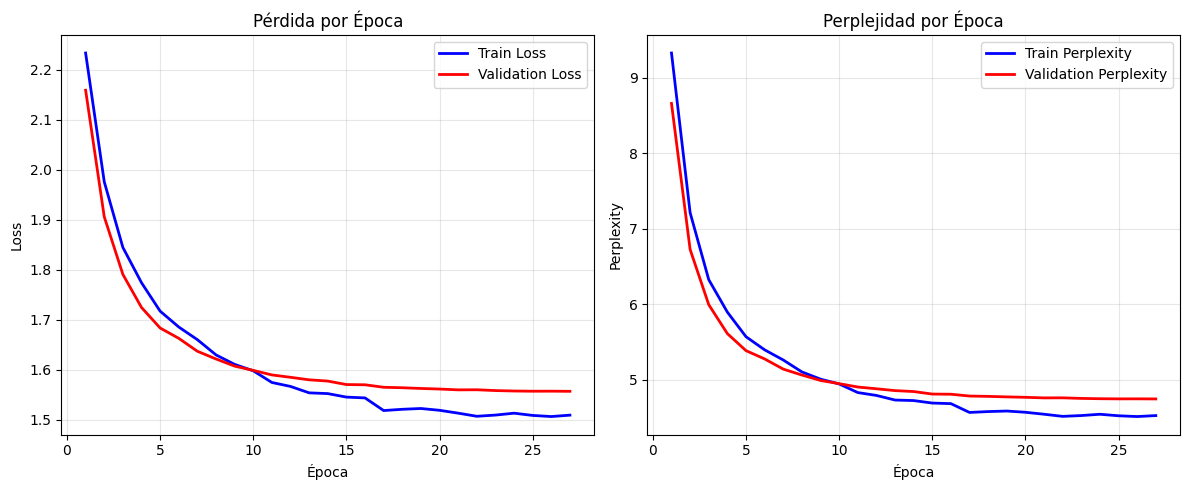

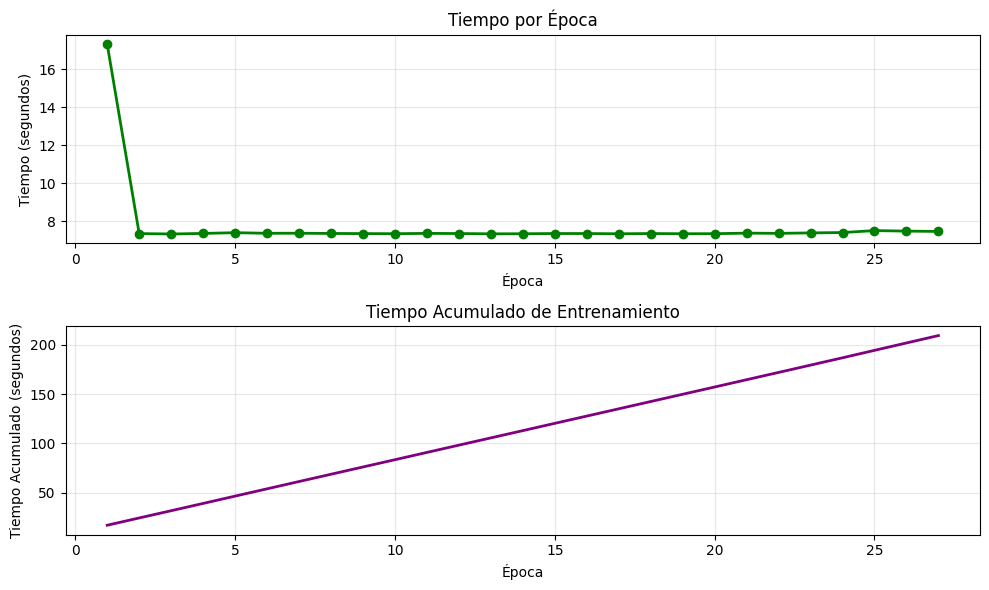


=== Resumen de Entrenamiento ===
Épocas totales: 27
Tiempo total: 209.17s (3.5 min)
Tiempo promedio por época: 7.75s
Loss final - Train: 1.5097, Val: 1.5573
Perplexity final - Train: 4.5252, Val: 4.7459


In [62]:
# Visualizar métricas de un modelo
metrics = load_and_plot_metrics("tinygpt_metrics.json", save_plots=True)



El análisis de las curvas de loss y perplejidad muestra que el modelo presenta un aprendizaje efectivo durante las primeras épocas, con una disminución pronunciada tanto en entrenamiento como en validación. A partir de la época 10–15, la validación alcanza una meseta y deja de mejorar de manera significativa, mientras que el entrenamiento continúa reduciendo la pérdida. Este comportamiento indica que el modelo ha capturado los patrones principales de los datos y que, más allá de ese punto, el entrenamiento adicional aporta mejoras únicamente sobre el conjunto de entrenamiento. Esta situación muestra indicios de overfitting, confirmado al extender el entrenamiento hasta 30 épocas, donde la separación entre entrenamiento y validación se intensifica. La incorporación de otras formas de regularización, early stopping, dropout o weight decay, podría contribuir ayudar a mejorar este proceso de entrenamiento.

#### Prueba rápida

In [63]:
generate(model=model, prompt="To be", max_new_tokens=100, use_cache=True, device=device) 

'To be rathers you shall in my price--to shall waw all so, both gods a\ncome! Come, or him sounded proud.\n\n'

## Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)

In [64]:
# TODO Implementar decodificación Greedy, Temperature y top_k/top_p
@torch.no_grad()
def generateV2(
    model: torch.nn.Module,
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
    do_sample: bool = True,
    device: torch.device = None
) -> str:
    """
    Función de generación mejorada con múltiples estrategias de decodificación.
    
    Args:
        model: Modelo TinyGPT entrenado
        prompt: Texto inicial para la generación
        max_new_tokens: Número máximo de tokens a generar
        use_cache: Si usar KV cache para acelerar la inferencia
        temperature: Temperatura para el muestreo (1.0 = sin cambios, <1 = más conservador, >1 = más aleatorio)
        top_k: Número de tokens top-k a considerar (0 = desactivado)
        top_p: Umbral de probabilidad acumulada para nucleus sampling (1.0 = desactivado)
        do_sample: Si usar muestreo (False = greedy decoding)
        device: Device donde ejecutar la inferencia
    
    Returns:
        Texto generado completo (prompt + tokens generados)
    """
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None
    
    for _ in range(max_new_tokens):
        # Preparar input condicionado según si usamos cache
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]  # Solo el último token
        else:
            idx_cond = idx[:, -config.block_size:]  # Ventana completa
        
        # Forward pass
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)
        
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None
        
        # Obtener logits del último token
        logits = logits[:, -1, :] / temperature  # Aplicar temperatura
        
        if do_sample:
            # === MUESTREO ===
            
            # Top-k filtering
            if top_k > 0:
                # Obtener los top-k logits más altos
                top_k_logits, top_k_indices = torch.topk(logits, min(top_k, logits.size(-1)))
                # Crear máscara para filtrar el resto
                logits_filtered = torch.full_like(logits, float('-inf'))
                logits_filtered.scatter_(1, top_k_indices, top_k_logits)
                logits = logits_filtered
            
            # Top-p (nucleus) filtering
            if top_p < 1.0:
                # Ordenar logits de mayor a menor
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                # Calcular probabilidades acumuladas
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                
                # Crear máscara para tokens que exceden top_p
                sorted_indices_to_remove = cumulative_probs > top_p
                # Mantener al menos el primer token (el más probable)
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                
                # Aplicar máscara a logits ordenados
                sorted_logits[sorted_indices_to_remove] = float('-inf')
                # Reordenar de vuelta a posiciones originales
                logits = torch.gather(sorted_logits, 1, sorted_indices.argsort(1))
            
            # Convertir a probabilidades y muestrear
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
        else:
            # === DECODIFICACIÓN GREEDY ===
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
        
        # Concatenar el nuevo token
        idx = torch.cat((idx, next_token), dim=1)
    
    return decode(idx[0].tolist())


def top_k_top_p_filtering(logits: torch.Tensor, top_k: int = 0, top_p: float = 1.0) -> torch.Tensor:
    """
    Función auxiliar para filtrado top-k y top-p.
    """
    if top_k > 0:
        # Top-k filtering
        top_k = min(max(top_k, 1), logits.size(-1))  # Safety check
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = float('-inf')

    if top_p < 1.0:
        # Top-p filtering
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        # Scatter sorted tensors to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = float('-inf')
    
    return logits


# Función de conveniencia para diferentes modos de generación
@torch.no_grad()
def generate_greedy(model, prompt: str, max_new_tokens: int = 100, **kwargs):
    """Generación greedy (determinística)"""
    return generateV2(
        model=model, 
        prompt=prompt, 
        max_new_tokens=max_new_tokens, 
        do_sample=False, 
        **kwargs
    )


@torch.no_grad()
def generate_with_temperature(model, prompt: str, temperature: float = 0.8, max_new_tokens: int = 100, **kwargs):
    """Generación con temperatura"""
    return generateV2(
        model=model, 
        prompt=prompt, 
        max_new_tokens=max_new_tokens, 
        temperature=temperature, 
        do_sample=True, 
        top_k=0, 
        top_p=1.0, 
        **kwargs
    )


@torch.no_grad()
def generate_top_k(model, prompt: str, top_k: int = 10, max_new_tokens: int = 100, **kwargs):
    """Generación con top-k sampling"""
    return generateV2(
        model=model, 
        prompt=prompt, 
        max_new_tokens=max_new_tokens, 
        top_k=top_k, 
        top_p=1.0, 
        do_sample=True, 
        **kwargs
    )


@torch.no_grad()
def generate_nucleus(model, prompt: str, top_p: float = 0.9, max_new_tokens: int = 100, **kwargs):
    """Generación con nucleus (top-p) sampling"""
    return generateV2(
        model=model, 
        prompt=prompt, 
        max_new_tokens=max_new_tokens, 
        top_k=0, 
        top_p=top_p, 
        do_sample=True, 
        **kwargs
    )

La función *generateV2* implementa múltiples estrategias de decodificación mediante parámetros configurables que permiten seleccionar entre decodificación *greedy* determinística (do_sample=False) o muestreo estocástico con control de temperatura, filtrado top-k y nucleus sampling (top-p). 

#### Comparar `generate` vs `generateV2`

In [65]:
# Comparar diferentes métodos de generación
prompt = "To be"

print("=== GENERACIÓN ORIGINAL ===")
result_original = generate(model=model, prompt=prompt, max_new_tokens=50, use_cache=True, device=device)
print(result_original)

print("\n=== DECODIFICACIÓN GREEDY ===")
result_greedy = generate_greedy(model, prompt, max_new_tokens=50, device=device)
print(result_greedy)

print("\n=== MUESTREO CON TEMPERATURA (0.5) ===")
result_temp_low = generate_with_temperature(model, prompt, temperature=0.5, max_new_tokens=50, device=device)
print(result_temp_low)

print("\n=== MUESTREO CON TEMPERATURA (1.5) ===")
result_temp_high = generate_with_temperature(model, prompt, temperature=1.5, max_new_tokens=50, device=device)
print(result_temp_high)

print("\n=== TOP-K SAMPLING (k=5) ===")
result_top_k = generate_top_k(model, prompt, top_k=5, max_new_tokens=50, device=device)
print(result_top_k)

print("\n=== NUCLEUS SAMPLING (p=0.9) ===")
result_nucleus = generate_nucleus(model, prompt, top_p=0.9, max_new_tokens=50, device=device)
print(result_nucleus)

print("\n=== COMBINADO: Top-k + Top-p + Temperatura ===")
result_combined = generateV2(
    model=model, 
    prompt=prompt, 
    max_new_tokens=50, 
    temperature=0.8, 
    top_k=10, 
    top_p=0.9, 
    device=device
)
print(result_combined)

=== GENERACIÓN ORIGINAL ===
To betterely do look's you serve drulars, a he
word you

=== DECODIFICACIÓN GREEDY ===
To be the people, and the people,
The common the people

=== MUESTREO CON TEMPERATURA (0.5) ===
To be the trank the give have that one many not the sen

=== MUESTREO CON TEMPERATURA (1.5) ===
To bear.
Peaced? How time his: to Kidjus, he people, sw

=== TOP-K SAMPLING (k=5) ===
To been as he straing him;
And this no make to
plucks y

=== NUCLEUS SAMPLING (p=0.9) ===
To be their put be state him compt
This and the parst f

=== COMBINADO: Top-k + Top-p + Temperatura ===
To be that such as the matter was so make your purpose 


Los resultados muestran que la elección del método de decodificación impacta directamente en la calidad, coherencia y creatividad del texto generado. 

La decodificación greedy produce salidas más consistentes y gramaticalmente estables, pero tiende a ser repetitiva, como se observa en la secuencia “the people, and the people…”. 

En contraste, el muestreo con temperaturas extremas refleja el trade-off entre control y aleatoriedad: con temperatura baja (0.5) el texto es más predecible pero rígido, mientras que con temperatura alta (1.5) se introduce variedad y creatividad, aunque a costa de coherencia y aparición de palabras sin sentido (“Kidjus, sw”).

Los métodos basados en restricciones probabilísticas, top-k y nucleus sampling (top-p), logran un mejor balance: evitan repeticiones y parecen tener más sentido. La versión combinada (top-k + top-p + temperatura) ofrece el resultado más natural dentro de las muestras observadas, con frases que mantienen mayor coherencia narrativa (“…such as the matter was so make your purpose”).

## Tarea II

Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [66]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        return self.net(x)


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [71]:
class MoELayer(nn.Module):
    """
    Versión optimizada de MoE con mejor paralelización
    """
    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)
        self.gate = gate
        self.args = moe_args
        self.num_experts = len(experts)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, n_embd = x.shape
        x_flat = x.view(-1, n_embd)
        
        # Gate computation
        gate_logits = self.gate(x_flat)
        gate_scores = F.softmax(gate_logits, dim=-1)
        
        # Top-k selection
        top_k_scores, top_k_indices = torch.topk(
            gate_scores, k=self.args.num_experts_per_token, dim=-1
        )
        top_k_scores = top_k_scores / top_k_scores.sum(dim=-1, keepdim=True)
        
        # Preparar para procesamiento paralelo
        output = torch.zeros_like(x_flat)
        
        # Procesar todos los expertos en paralelo cuando sea posible
        for expert_idx, expert in enumerate(self.experts):
            # Máscara más eficiente
            expert_mask = (top_k_indices == expert_idx)
            if expert_mask.any():
                # Obtener pesos y posiciones
                weights = top_k_scores * expert_mask.float()
                weights_sum = weights.sum(dim=-1, keepdim=True)
                
                # Solo procesar tokens que realmente usan este experto
                active_tokens = weights_sum.squeeze() > 0
                if active_tokens.any():
                    expert_input = x_flat[active_tokens]
                    expert_out = expert(expert_input)
                    
                    # Aplicar pesos de forma vectorizada
                    final_weights = weights_sum[active_tokens]
                    output[active_tokens] += final_weights * expert_out
        
        return output.view(batch_size, seq_len, n_embd)

In [72]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(  
            experts=[Expert(config) for _ in range(config.moe.num_experts)],
            gate=Gate(config),
            moe_args=config.moe
        )

    def forward(self, x):
        return self.moe(x)

Las clases **Expert** y **Gate** forman la base del sistema *Mixture of Experts*. La clase **Expert** implementa una red neuronal MLP especializada que replica la estructura de la capa feed-forward estándar (64→256→64 dimensiones con activación ReLU y dropout), pero permite que cada experto se especialice en diferentes patrones durante el entrenamiento. La clase **Gate** actúa como el mecanismo de routing que decide qué expertos activar para cada token, utilizando una transformación lineal que mapea las representaciones de entrada (n_embd) a puntuaciones para cada experto disponible (num_experts), implementando así el aprendizaje de la función de decisión que determina la especialización de expertos.


La clase **MoELayer** implementa el núcleo del sistema de expertos múltiples, procesando tokens mediante top-k selection donde cada token es enrutado a los k expertos más relevantes según las puntuaciones del gate. **MoEFFN** actúa como wrapper que integra el sistema **MoE** en la arquitectura transformer existente, reemplazando las capas feed-forward. 

Esta implementación permite que el modelo escale su capacidad añadiendo expertos especializados sin incrementar proporcionalmente el costo computacional por token, ya que solo se activan los expertos seleccionados durante cada pasada forward.

#### Añadiendo MoE a la configuración

In [73]:
config.ff_class = MoEFFN
config.moe = MoEArgs(num_experts=4, num_experts_per_token=1)

config.batch_size = 256  # Reducir batch size para compensar mayor uso de memoria

La elección de 4 expertos en la configuración MoE se basa en un balance entre capacidad del modelo y eficiencia computacional. Con num_experts_per_token=1, cada token activa únicamente 1 de los 4 expertos disponibles, lo que significa que solo el 25% de los parámetros de la capa feed-forward se utilizan por token durante la pasada forward. Esto permite que el modelo tenga 4 veces más parámetros especializados (cada experto puede aprender patrones diferentes) mientras mantiene el costo computacional similar al modelo base.

#### Entrenamiento de TinyGPT‑MoE

In [74]:
print(device)

cuda


In [75]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m_moe)

In [77]:
# Optimizer, scheduler, and loss function
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
# scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
total_steps = len(train_loader) * epochs
scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 27

In [78]:
logger = MetricsLogger("moe_metrics.json")

trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints_moe",
    save_every_n=500,
)

# Entrenamiento con logging
logger.start_training()

for epoch in range(epochs):
    logger.start_epoch()
    
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    val_loss = trainer.eval_model()
    
    # Corregir la pérdida de entrenamiento si está dividida por gradient_accumulation_steps
    corrected_train_loss = avg_train_loss * trainer.gradient_accumulation_steps
    
    # Log de métricas
    logger.log_epoch(corrected_train_loss, val_loss)

logger.end_training()
logger.save_metrics()

print("Entrenamiento completo.")

  0%|          | 0/175 [00:00<?, ?it/s]/home/jgonzalez/dev/.virtualenv/ceia-nlp-II-tp-1/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2509: UserWarning: NVIDIA GeForce GTX 1650 Ti does not support bfloat16 compilation natively, skipping
  warnings.warn(
/home/jgonzalez/dev/.virtualenv/ceia-nlp-II-tp-1/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:2509: UserWarning: NVIDIA GeForce GTX 1650 Ti does not support bfloat16 compilation natively, skipping
  warnings.warn(
val_loss 1.97225: 100%|██████████| 19/19 [00:00<00:00, 28.13it/s]


Época 1 - Train Loss: 2.2017 - Val Loss: 2.1222
Train Perplexity: 9.0403 - Val Perplexity: 8.3495
Tiempo de época: 12.24s


val_loss 1.70045: 100%|██████████| 19/19 [00:00<00:00, 36.66it/s]


Época 2 - Train Loss: 1.9511 - Val Loss: 1.8716
Train Perplexity: 7.0367 - Val Perplexity: 6.4987
Tiempo de época: 10.74s


val_loss 1.61767: 100%|██████████| 19/19 [00:00<00:00, 37.31it/s]


Época 3 - Train Loss: 1.8280 - Val Loss: 1.7648
Train Perplexity: 6.2216 - Val Perplexity: 5.8403
Tiempo de época: 10.63s


val_loss 1.56175: 100%|██████████| 19/19 [00:00<00:00, 36.84it/s]


Época 4 - Train Loss: 1.7535 - Val Loss: 1.7097
Train Perplexity: 5.7747 - Val Perplexity: 5.5272
Tiempo de época: 10.72s


val_loss 1.52725: 100%|██████████| 19/19 [00:00<00:00, 36.70it/s]


Época 5 - Train Loss: 1.7070 - Val Loss: 1.6719
Train Perplexity: 5.5123 - Val Perplexity: 5.3224
Tiempo de época: 10.73s


val_loss 1.50381: 100%|██████████| 19/19 [00:00<00:00, 35.26it/s]


Época 6 - Train Loss: 1.6663 - Val Loss: 1.6488
Train Perplexity: 5.2927 - Val Perplexity: 5.2005
Tiempo de época: 10.67s


val_loss 1.48093: 100%|██████████| 19/19 [00:00<00:00, 37.19it/s]


Época 7 - Train Loss: 1.6364 - Val Loss: 1.6319
Train Perplexity: 5.1368 - Val Perplexity: 5.1137
Tiempo de época: 10.69s


val_loss 1.46540: 100%|██████████| 19/19 [00:00<00:00, 37.67it/s]


Época 8 - Train Loss: 1.6103 - Val Loss: 1.6145
Train Perplexity: 5.0041 - Val Perplexity: 5.0254
Tiempo de época: 10.65s


val_loss 1.44820: 100%|██████████| 19/19 [00:00<00:00, 34.60it/s]


Época 9 - Train Loss: 1.5913 - Val Loss: 1.6023
Train Perplexity: 4.9101 - Val Perplexity: 4.9643
Tiempo de época: 10.69s


val_loss 1.43552: 100%|██████████| 19/19 [00:00<00:00, 37.36it/s]


Época 10 - Train Loss: 1.5736 - Val Loss: 1.5932
Train Perplexity: 4.8238 - Val Perplexity: 4.9195
Tiempo de época: 10.84s


val_loss 1.42907: 100%|██████████| 19/19 [00:00<00:00, 35.86it/s]


Época 11 - Train Loss: 1.5556 - Val Loss: 1.5860
Train Perplexity: 4.7379 - Val Perplexity: 4.8844
Tiempo de época: 10.63s


val_loss 1.42753: 100%|██████████| 19/19 [00:00<00:00, 38.09it/s]


Época 12 - Train Loss: 1.5468 - Val Loss: 1.5789
Train Perplexity: 4.6962 - Val Perplexity: 4.8498
Tiempo de época: 10.60s


val_loss 1.41892: 100%|██████████| 19/19 [00:00<00:00, 37.30it/s]


Época 13 - Train Loss: 1.5337 - Val Loss: 1.5727
Train Perplexity: 4.6352 - Val Perplexity: 4.8195
Tiempo de época: 10.58s


val_loss 1.40693: 100%|██████████| 19/19 [00:00<00:00, 33.37it/s]


Época 14 - Train Loss: 1.5318 - Val Loss: 1.5694
Train Perplexity: 4.6263 - Val Perplexity: 4.8036
Tiempo de época: 10.70s


val_loss 1.40951: 100%|██████████| 19/19 [00:00<00:00, 34.22it/s]


Época 15 - Train Loss: 1.5146 - Val Loss: 1.5660
Train Perplexity: 4.5478 - Val Perplexity: 4.7874
Tiempo de época: 10.94s


val_loss 1.39908: 100%|██████████| 19/19 [00:00<00:00, 34.36it/s]


Época 16 - Train Loss: 1.5148 - Val Loss: 1.5613
Train Perplexity: 4.5486 - Val Perplexity: 4.7650
Tiempo de época: 10.94s


val_loss 1.39891: 100%|██████████| 19/19 [00:00<00:00, 33.34it/s]


Época 17 - Train Loss: 1.5027 - Val Loss: 1.5600
Train Perplexity: 4.4940 - Val Perplexity: 4.7589
Tiempo de época: 11.12s


val_loss 1.39427: 100%|██████████| 19/19 [00:00<00:00, 34.52it/s]


Época 18 - Train Loss: 1.4948 - Val Loss: 1.5571
Train Perplexity: 4.4584 - Val Perplexity: 4.7451
Tiempo de época: 11.10s


val_loss 1.39076: 100%|██████████| 19/19 [00:00<00:00, 33.92it/s]


Época 19 - Train Loss: 1.4953 - Val Loss: 1.5551
Train Perplexity: 4.4607 - Val Perplexity: 4.7358
Tiempo de época: 10.75s


val_loss 1.39477: 100%|██████████| 19/19 [00:00<00:00, 33.92it/s]


Época 20 - Train Loss: 1.4883 - Val Loss: 1.5552
Train Perplexity: 4.4297 - Val Perplexity: 4.7361
Tiempo de época: 10.77s


val_loss 1.38829: 100%|██████████| 19/19 [00:00<00:00, 35.69it/s]


Época 21 - Train Loss: 1.4887 - Val Loss: 1.5532
Train Perplexity: 4.4313 - Val Perplexity: 4.7263
Tiempo de época: 11.27s


val_loss 1.39145: 100%|██████████| 19/19 [00:00<00:00, 38.62it/s]


Época 22 - Train Loss: 1.4830 - Val Loss: 1.5539
Train Perplexity: 4.4060 - Val Perplexity: 4.7297
Tiempo de época: 10.79s


val_loss 1.39302: 100%|██████████| 19/19 [00:00<00:00, 37.94it/s]


Época 23 - Train Loss: 1.4875 - Val Loss: 1.5536
Train Perplexity: 4.4262 - Val Perplexity: 4.7284
Tiempo de época: 10.62s


val_loss 1.39217: 100%|██████████| 19/19 [00:00<00:00, 39.08it/s]


Época 24 - Train Loss: 1.4773 - Val Loss: 1.5531
Train Perplexity: 4.3813 - Val Perplexity: 4.7262
Tiempo de época: 10.42s


val_loss 1.39175: 100%|██████████| 19/19 [00:00<00:00, 31.16it/s]


Época 25 - Train Loss: 1.4810 - Val Loss: 1.5530
Train Perplexity: 4.3972 - Val Perplexity: 4.7257
Tiempo de época: 10.83s


val_loss 1.39163: 100%|██████████| 19/19 [00:00<00:00, 38.04it/s]


Época 26 - Train Loss: 1.4826 - Val Loss: 1.5530
Train Perplexity: 4.4046 - Val Perplexity: 4.7256
Tiempo de época: 11.04s


val_loss 1.39226: 100%|██████████| 19/19 [00:00<00:00, 37.52it/s]

Época 27 - Train Loss: 1.4833 - Val Loss: 1.5530
Train Perplexity: 4.4075 - Val Perplexity: 4.7254
Tiempo de época: 10.63s
Entrenamiento completo. Tiempo total: 292.28s
Métricas guardadas en moe_metrics.json
Entrenamiento completo.


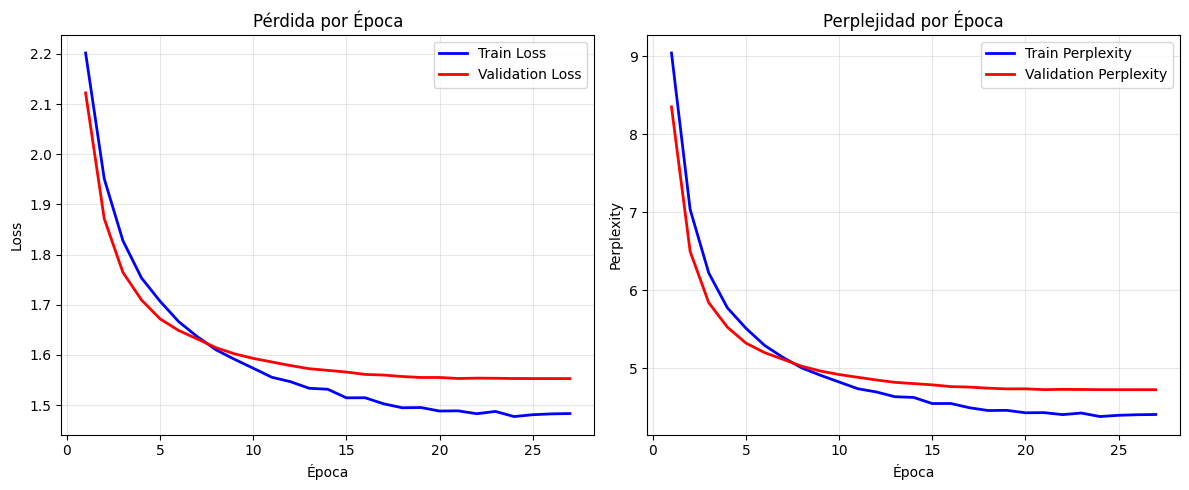

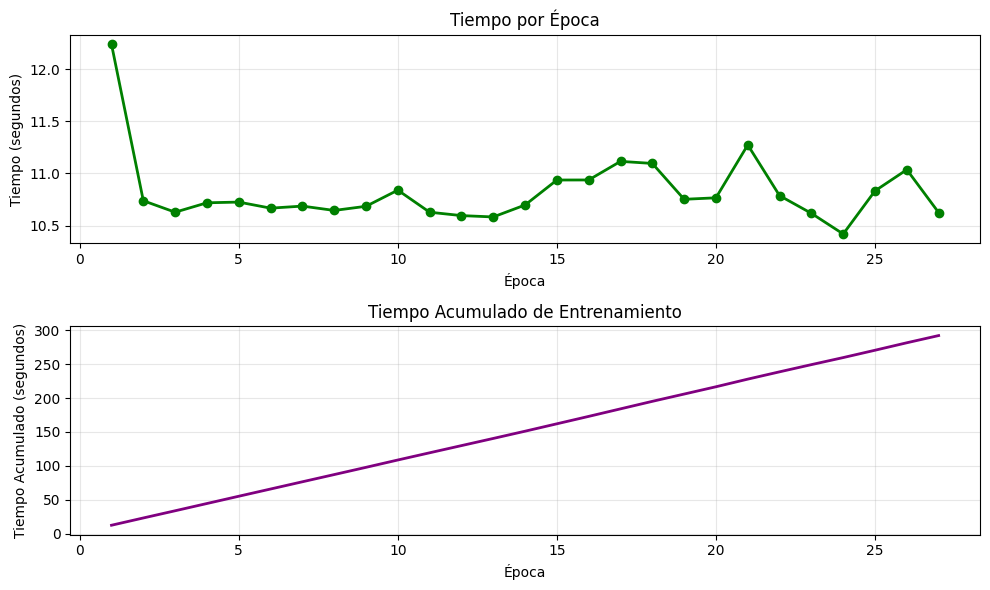


=== Resumen de Entrenamiento ===
Épocas totales: 27
Tiempo total: 292.28s (4.9 min)
Tiempo promedio por época: 10.83s
Loss final - Train: 1.4833, Val: 1.5530
Perplexity final - Train: 4.4075, Val: 4.7254


In [79]:
# Visualizar métricas de un modelo
metrics = load_and_plot_metrics("moe_metrics.json", save_plots=True)

In [80]:
generate(model=model_moe, prompt="To be", max_new_tokens=100, use_cache=True, device=device) 

'To be confirmy.\n\nSICINIUS:\nPatexconsul\nTawardst consul to them tribune; for to their can do we did\nThe ne'

In [81]:
# Comparar diferentes métodos de generación
prompt = "To be"

print("=== GENERACIÓN ORIGINAL ===")
result_original = generate(model=model_moe, prompt=prompt, max_new_tokens=50, use_cache=True, device=device)
print(result_original)

print("\n=== DECODIFICACIÓN GREEDY ===")
result_greedy = generate_greedy(model_moe, prompt, max_new_tokens=50, device=device)
print(result_greedy)

print("\n=== MUESTREO CON TEMPERATURA (0.5) ===")
result_temp_low = generate_with_temperature(model_moe, prompt, temperature=0.5, max_new_tokens=50, device=device)
print(result_temp_low)

print("\n=== MUESTREO CON TEMPERATURA (1.5) ===")
result_temp_high = generate_with_temperature(model_moe, prompt, temperature=1.5, max_new_tokens=50, device=device)
print(result_temp_high)

print("\n=== TOP-K SAMPLING (k=5) ===")
result_top_k = generate_top_k(model_moe, prompt, top_k=5, max_new_tokens=50, device=device)
print(result_top_k)

print("\n=== NUCLEUS SAMPLING (p=0.9) ===")
result_nucleus = generate_nucleus(model_moe, prompt, top_p=0.9, max_new_tokens=50, device=device)
print(result_nucleus)

print("\n=== COMBINADO: Top-k + Top-p + Temperatura ===")
result_combined = generateV2(
    model=model_moe, 
    prompt=prompt, 
    max_new_tokens=50, 
    temperature=0.8, 
    top_k=10, 
    top_p=0.9, 
    device=device
)
print(result_combined)

=== GENERACIÓN ORIGINAL ===
To be poors they
are dame not virdue; and have wan him 

=== DECODIFICACIÓN GREEDY ===
To be the people,
That he hath have son a part of the p

=== MUESTREO CON TEMPERATURA (0.5) ===
To bear he wonden the market-place;
The the people of t

=== MUESTREO CON TEMPERATURA (1.5) ===
To be cerei' ditines. The backerch, in own; reranter ha

=== TOP-K SAMPLING (k=5) ===
To bear a so son,
And may be heldst to
senator that wha

=== NUCLEUS SAMPLING (p=0.9) ===
To beinds of them. You success is caposition of stand,


=== COMBINADO: Top-k + Top-p + Temperatura ===
To be common as struck of you,
That be to he heart, the


#### Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [82]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Run forward with return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights is a list of length n_layers
    # each element: shape (n_heads, batch_size, seq_len, seq_len)
    # We'll visualize the first batch element only

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

##### TinyGPT

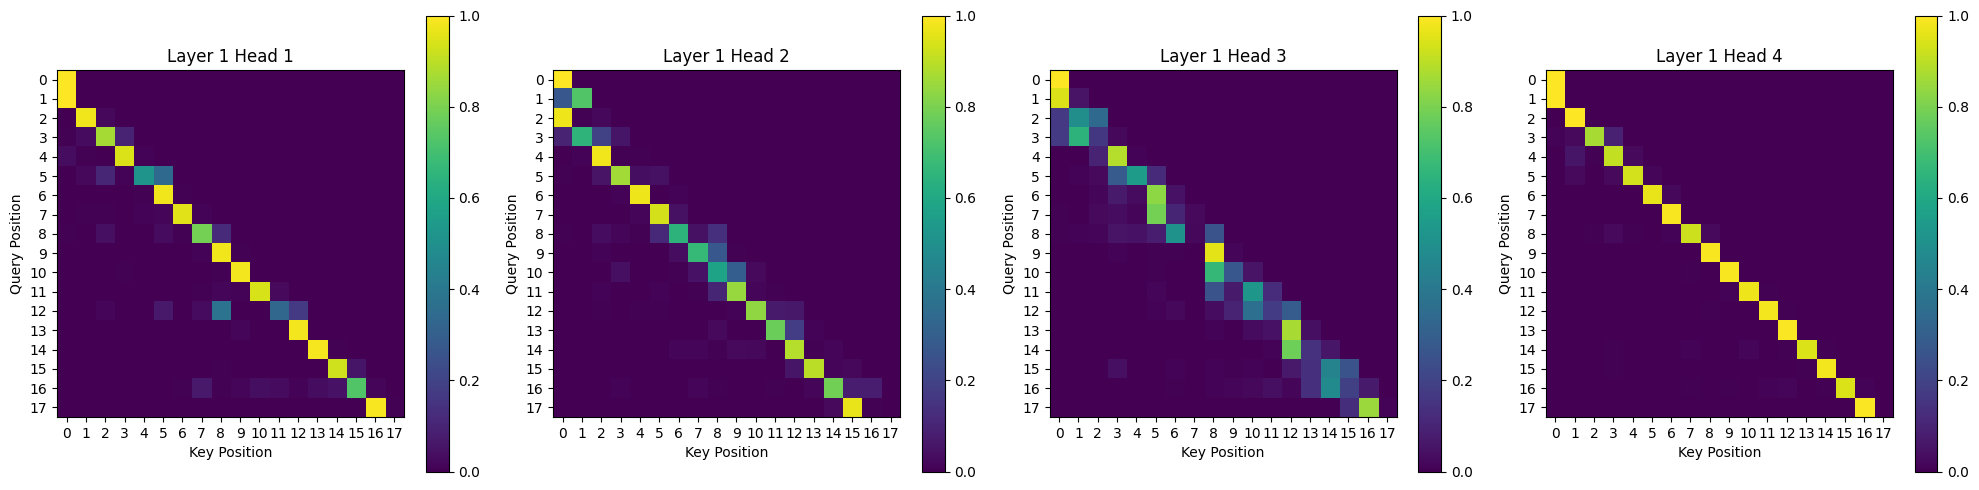

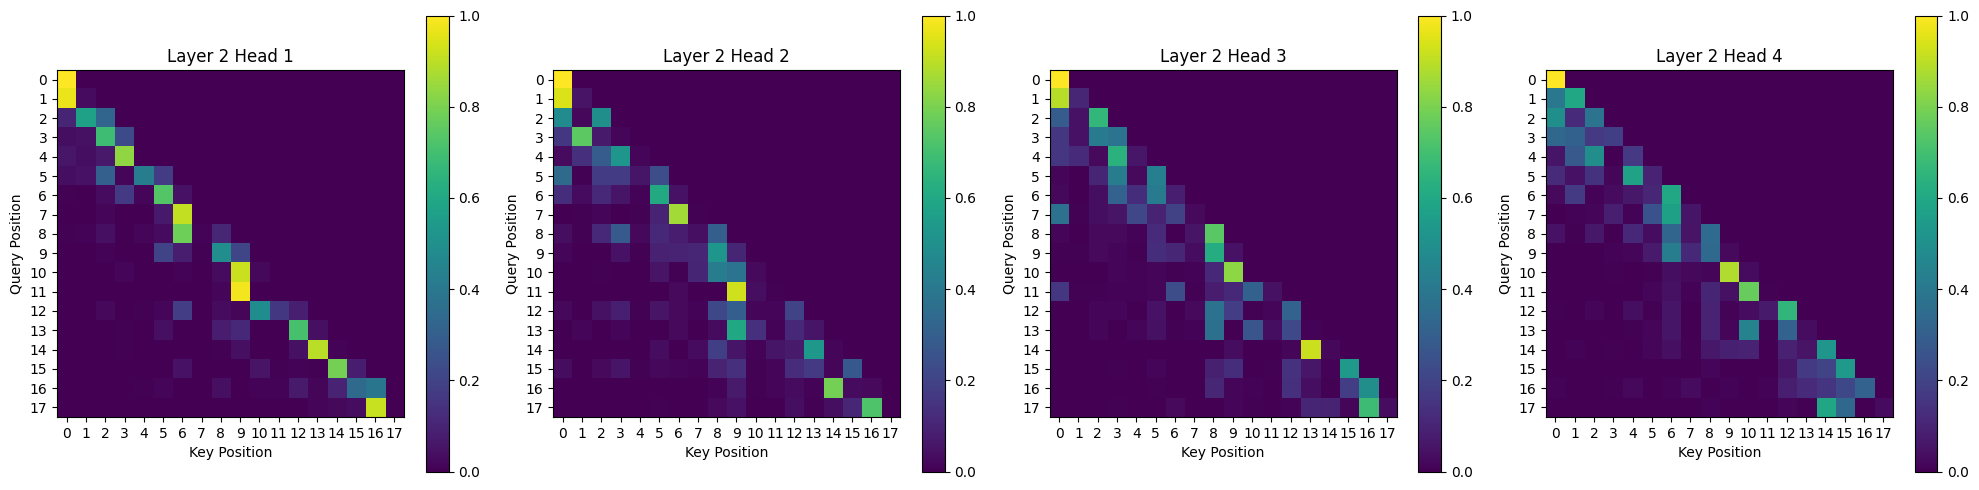

In [84]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

##### TinyGPT MoE

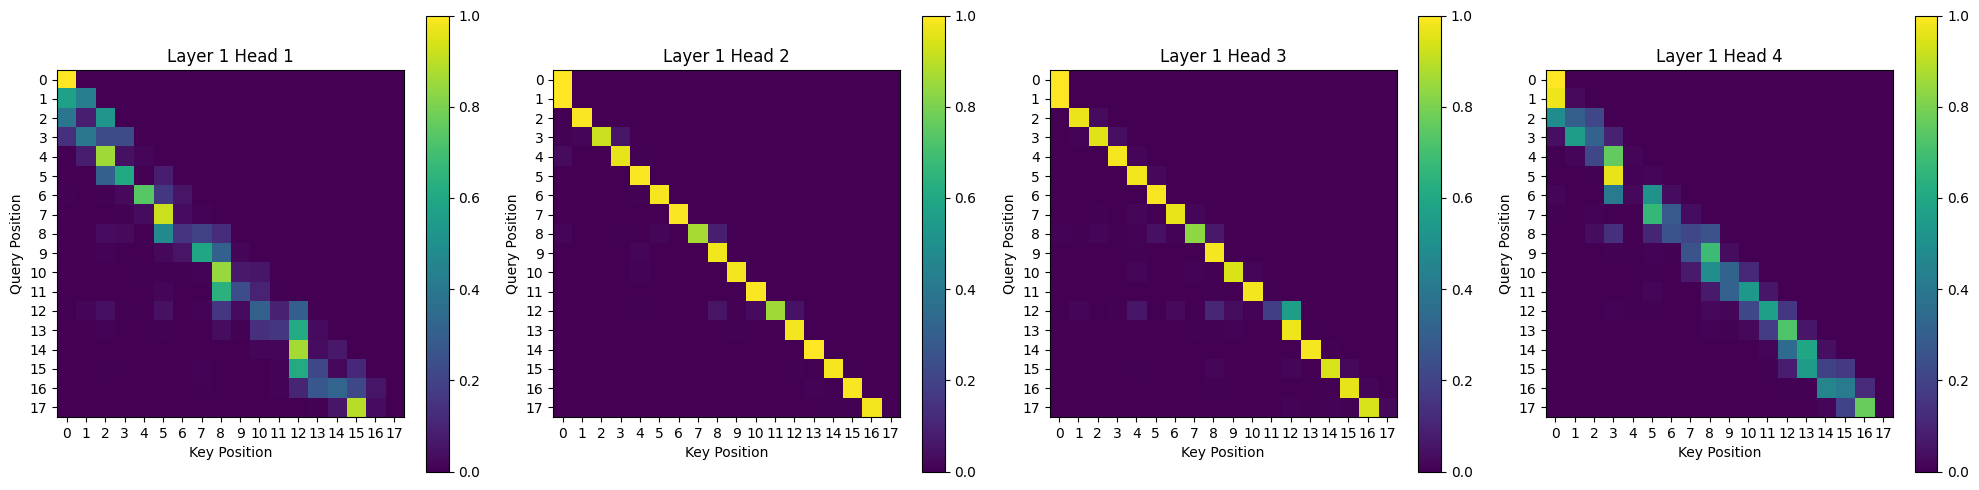

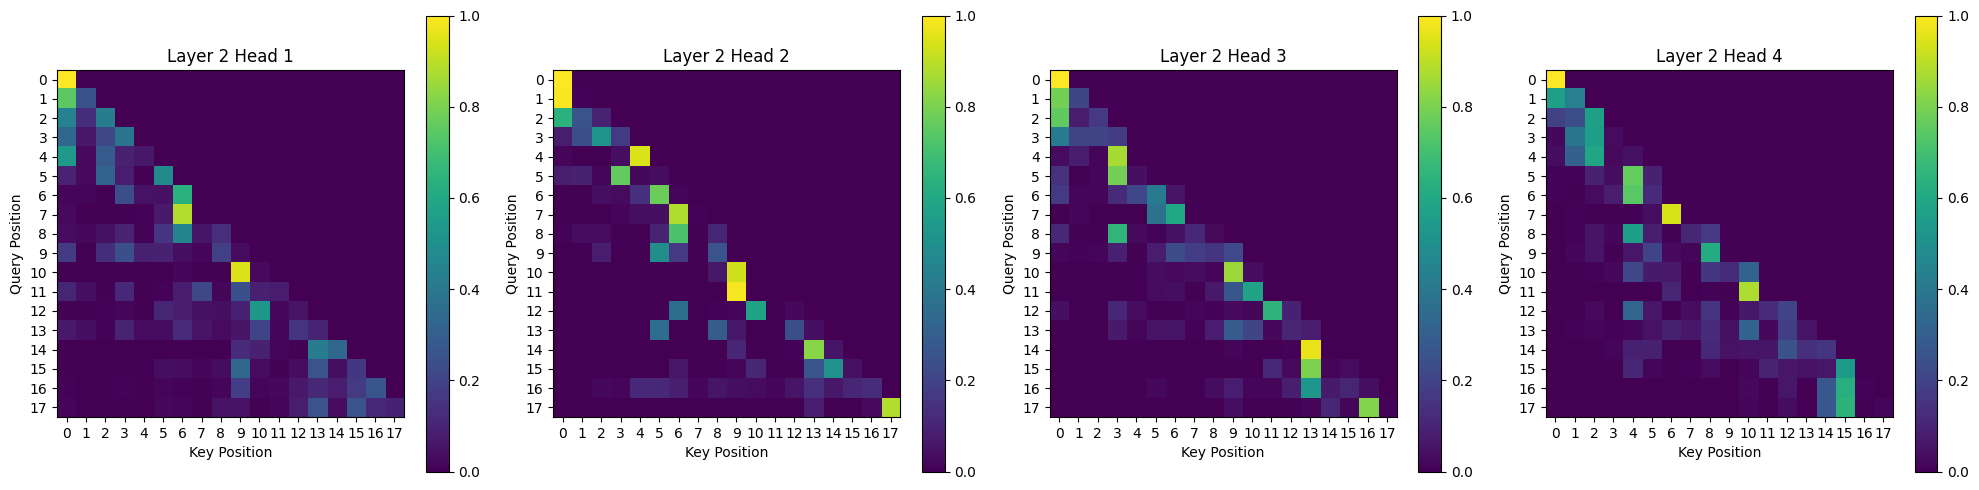

In [85]:
prompt = "To be or not to be"
visualize_attention(model_moe, prompt)

##### Comentarios

Estos gráficos muestran los mapas de atención de cada cabeza en las dos primeras capas del modelo. 

En el eje X estan las posiciones de las keys (tokens previos) y en el eje Y las queries (tokens actuales). El color indica cuánto “atención” dedica un token a otro al momento de calcular su representación: los amarillos son pesos de atención altos, los violetas bajos. En la primera imagen (TinyGPT estándar) vemos que varias cabezas de atención se enfocan fuertemente en la diagonal (cada token atendiendo sobre sí mismo o su vecino inmediato), con algunas cabezas en la segunda capa que empiezan a repartir peso sobre tokens más lejanos.

En cambio, en la segunda imagen (TinyGPT con MoE, mixture of experts) se nota que algunas cabezas presentan atenciones más dispersas o “especializadas”: por ejemplo, en la capa 1 head 3 se ve un patrón casi puramente diagonal (auto-atención fuerte), mientras que otras cabezas en capa 2 comienzan a saltar posiciones y distribuir atención más irregularmente. Esto sugiere que el enrutamiento hacia expertos distintos promueve cierta diversidad en los patrones de atención.

## Conclusiones

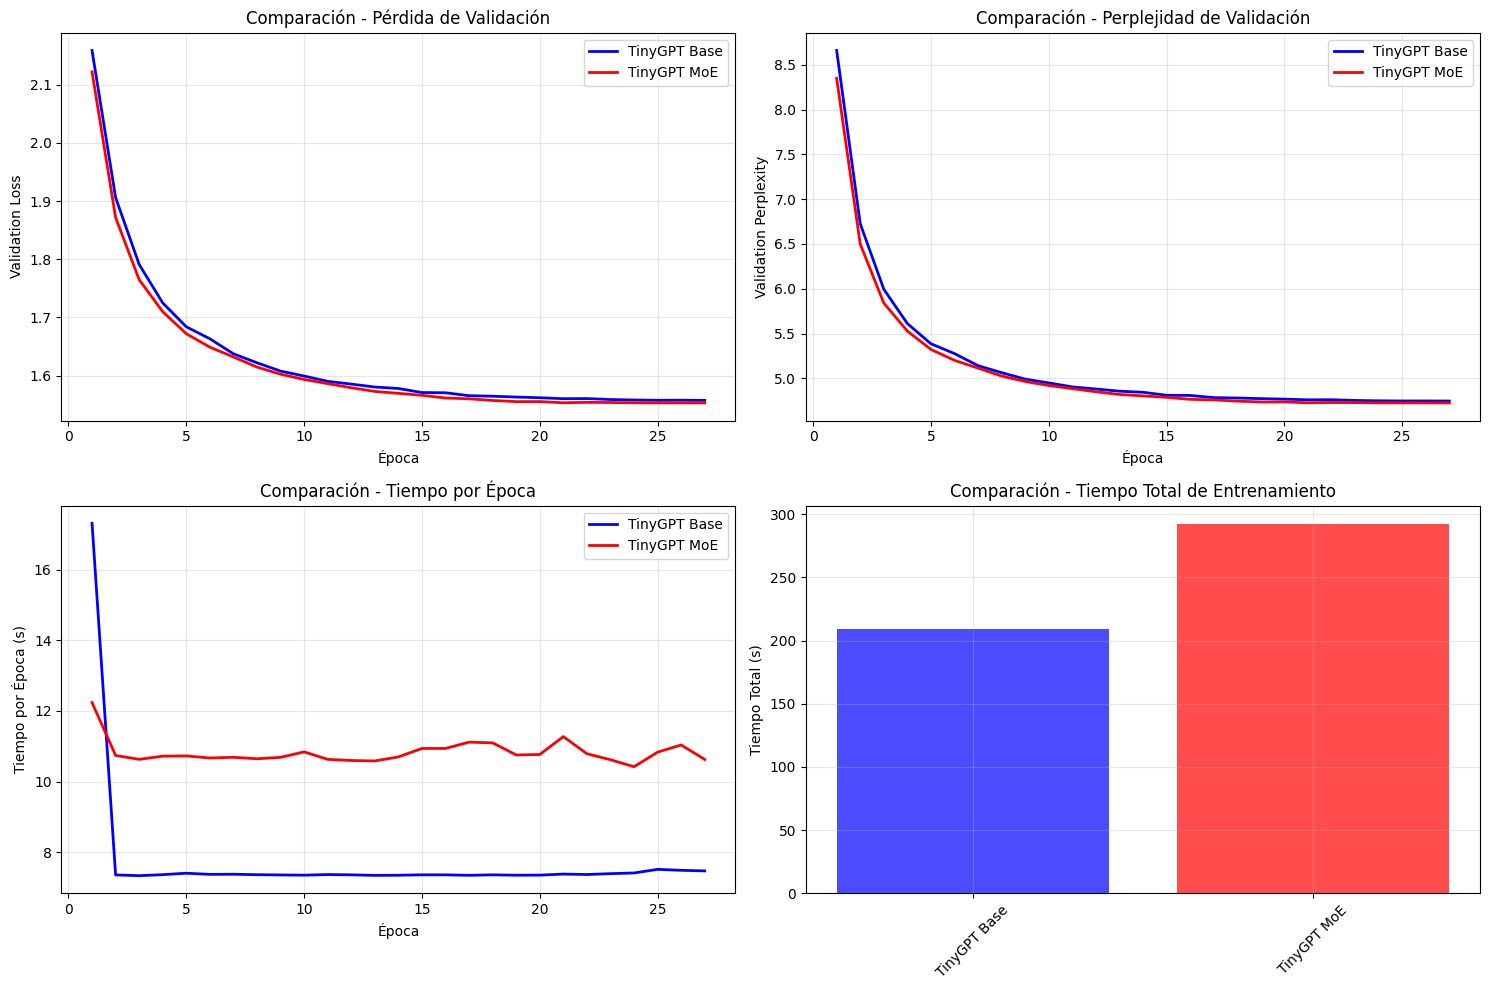

In [86]:
# Si tienes múltiples modelos para comparar:
compare_models_metrics(
    ["tinygpt_metrics.json", "moe_metrics.json"],
    ["TinyGPT Base", "TinyGPT MoE"]
)

**Con respecto a arquitectura, performance y tiempos de entrenamiento:**

MoE tiene una loss y perplexity de validación ligeramente mejor que el modelo base, pero no es una mejora dramática.

Tiempo de entrenamiento mayor, lo cual es esperable debiado a:

- 4x más parámetros en las capas feed-forward (4 expertos vs 1 FFN)
- Todos los expertos deben mantener gradientes y actualizarse
- Overhead computacional del gate network y routing
- Mayor uso de memoria (por eso redujiste batch_size de 512 a 256)

Sin embargo teniendo un modelo mas grande y especializado puede tener mismo tiempo de inferencia que TinyGPT estándar.

**Con respecto a inferencia:**

| Estrategia de Decodificación | TinyGPT Estándar | TinyGPT con MoE |
|-------------------------------|------------------|-----------------|
| **Generación Original (sin restricciones)** | Tiende a producir secuencias algo incoherentes, con palabras inventadas o deformadas. Ejemplo: *“To betterely do look's you serve drulars”*. | También inventa palabras, pero la variedad de formas es un poco mayor. Ejemplo: *“To be poors they are dame not virdue”*. |
| **Greedy Decoding** | Cae en repeticiones fuertes y frases determinísticas (“the people, the people”), mostrando falta de diversidad. | También repetitivo, pero con ligeras variaciones, menos rígido que el estándar. |
| **Muestreo con Temperatura (0.5)** | Genera frases más variadas pero con sintaxis débil, mezcla de sentido y sin sentido. Ejemplo: *“the give have that one many not the sen”*. | Similar, pero introduce más combinaciones de tokens que suenan un poco más naturales. Ejemplo: *“the people of t”*. |
| **Muestreo con Temperatura (1.5)** | Mucho ruido y alucinaciones, produce tokens raros pero con algo de ritmo. Ejemplo: *“Peaced? How time his: to Kidjus”*. | Igualmente caótico, pero con secuencias más fragmentadas y creativas. Ejemplo: *“cerei' ditines. The backerch”*. |
| **Top-k Sampling (k=5)** | Mezcla frases incompletas, a veces se corta el sentido. Ejemplo: *“To been as he straing him”*. | Similar, pero logra secuencias un poco más diversas y menos predecibles. Ejemplo: *“To bear a so son, And may be heldst”*. |
| **Nucleus Sampling (p=0.9)** | Produce secuencias con cierta estructura pero pierde coherencia. Ejemplo: *“This and the parst f”*. | Mantiene algo de coherencia en los inicios y mayor variabilidad al final. Ejemplo: *“You success is caposition of stand”*. |
| **Combinado (Top-k + Top-p + Temperatura)** | Más balanceado, logra frases con cierta lógica pero aún poco naturales. Ejemplo: *“so make your purpose”*. | Tiende a ser más expresivo y variado, aunque sigue siendo poco coherente. Ejemplo: *“as struck of you, That be to he heart”*. |


El TinyGPT estándar es más rígido y tiende a caer en bucles o repeticiones (“the people, the people”).

El TinyGPT con MoE muestra un poco más de diversidad y expresividad, sobre todo en top-k y nucleus, aunque ambos siguen limitados por su tamaño reducido.

